# Data normalization

Neste Notebook, foi realizada uma etapa de normalização de dados. Para tanto, foram importadas imagens de um dataset com 10 classes de componentes eletrônicos, cada uma com 5 itens.

Inicialmente, os canais de cores (RGB) foram extraídos separadamente para cada classe. O valor médio de cada canal foi calculado para cada classe. Com base nessa média foram geradas imagens representativas para cada canal e classe, permitindo uma melhor visualização das cores de cada classe.

Além disso, foram criados histogramas médios calculando a média dos histogramas individuais para cada canal em cada classe. Este método permite uma análise mais detalhada da distribuição de intensidade em cada canal de cor.

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import skimage as ski

In [ ]:
path = Path('./processed_images')
img_data = {}
img_names = []
for item in path.iterdir():
  for img in item.iterdir():
    img_names.append((item.name, img.name))
    img = ski.io.imread(img)
    if item.name not in img_data:
      img_data[item.name] = []
    img_data[item.name].append(img)

## Protótipo médio de cada classe

In [ ]:
def media_canais_classe(classe : list):
  ## R, G, B
  img_media_canais = [np.zeros_like(classe[0][:, :, 0], np.int32),
                      np.zeros_like(classe[0][:, :, 0], np.int32),
                      np.zeros_like(classe[0][:, :, 0], np.int32)]
  for img in classe:
    img_r, img_g, img_b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    img_media_canais[0] += img_r
    img_media_canais[1] += img_g
    img_media_canais[2] += img_b

  for i, img_canal in enumerate(img_media_canais):
    img_canal = img_canal / len(classe)
    img_media_canais[i] = img_canal

  return img_media_canais

media_classes_canais = {}
for classe in img_data.keys():
  media_classes_canais[classe] = media_canais_classe(img_data[classe])

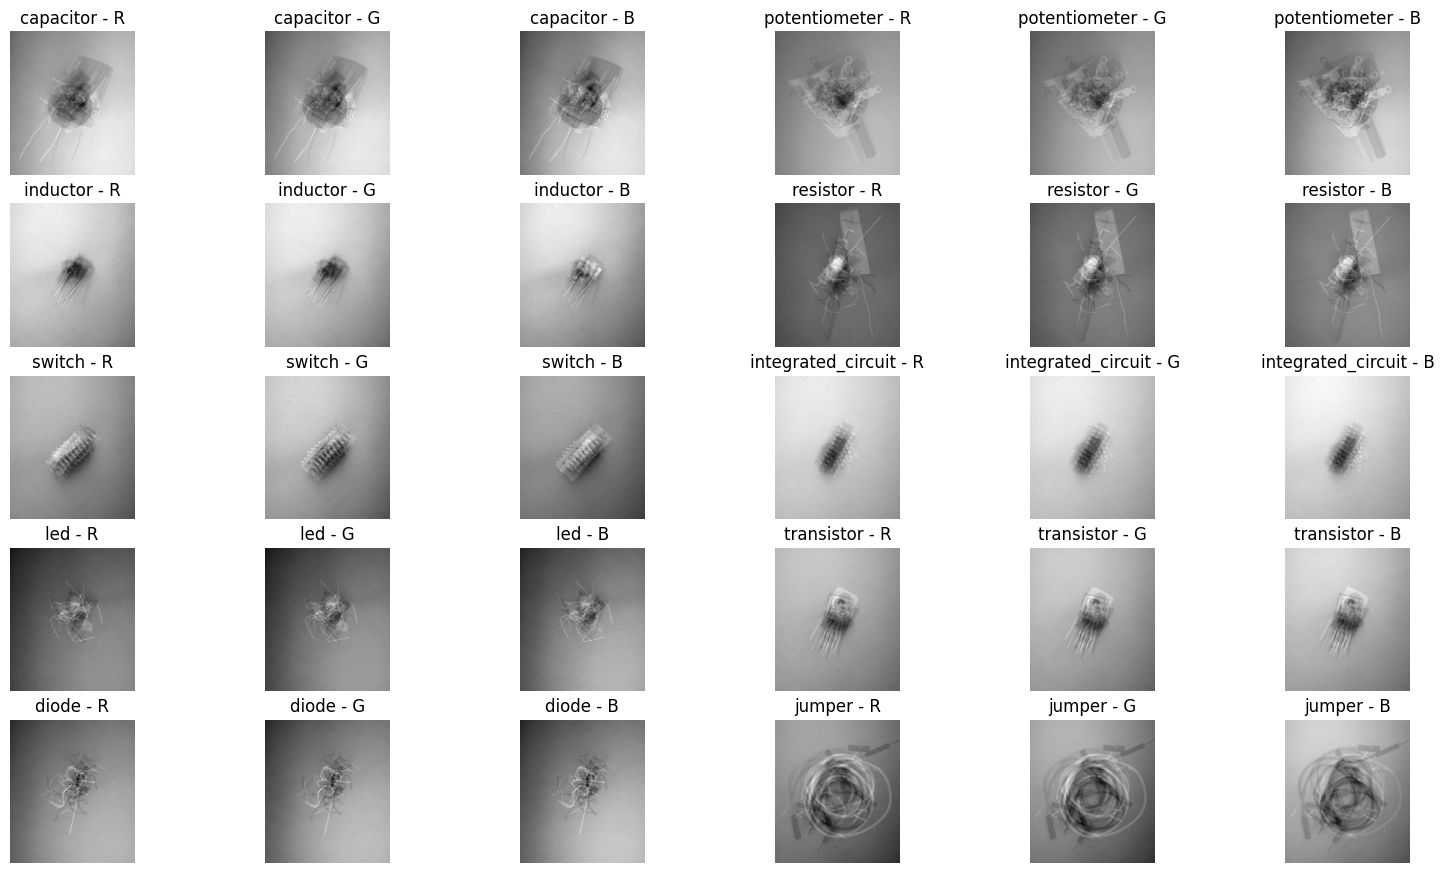

In [ ]:
fig, ax = plt.subplots(5, 6, figsize=(19.2, 10.8))
ax = ax.ravel()

rgb = ['R', 'G', 'B']
i = 0
for classe in media_classes_canais.keys():
  for j in range(0,3):
    ax[i + j].imshow(media_classes_canais[classe][j], cmap='gray')
    ax[i + j].set_title(f'{classe} - {rgb[j]}')
    ax[i + j].set_axis_off()
  i += 3

## Histograma médio dos canais de cada classe

In [9]:
def hist_medio_canais_classe(classe : list):
  hist_medio_canais = np.zeros((256, 3), dtype=np.int32)


  for img in classe:
    canais = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    for i, canal in enumerate(canais):
      hist, _ = ski.exposure.histogram(canal, nbins=256, source_range='dtype')
      hist_medio_canais[:, i] += hist

  for i in range(3):
    hist_medio_canais[:, i] = hist_medio_canais[:, i] / len(classe)

  return hist_medio_canais

hist_medio_classes = {}
for classe in img_data.keys():
  hist_medio_classes[classe] = hist_medio_canais_classe(img_data[classe])

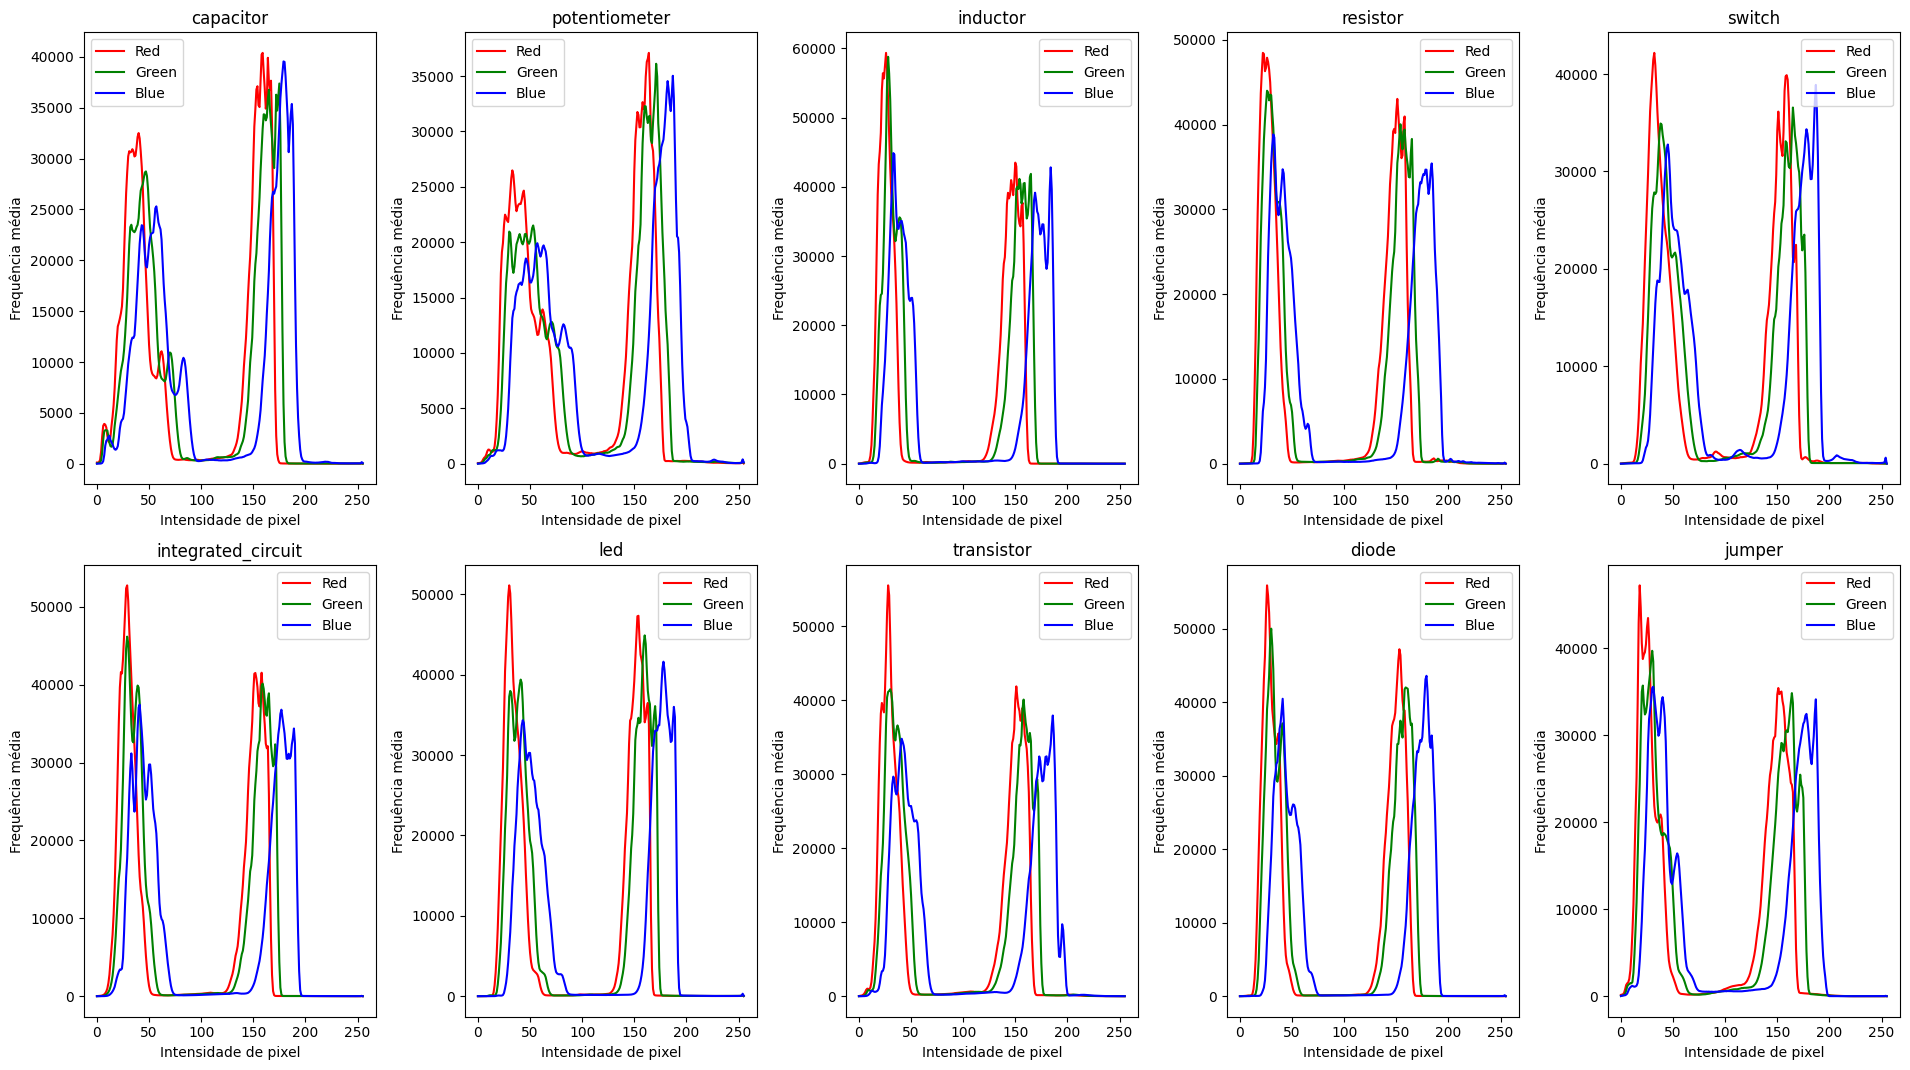

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(19.2, 10.8))
ax = ax.ravel()

cores = ['r', 'g', 'b']
label = ['Red', 'Green', 'Blue']

for i, classe in enumerate(hist_medio_classes.keys()):
  for j in range(3):
    ax[i].plot(hist_medio_classes[classe][:, j], color=cores[j], label=label[j])
  ax[i].set_title(classe)
  ax[i].set_xlabel('Intensidade de pixel')
  ax[i].set_ylabel('Frequência média')
  ax[i].legend()

plt.tight_layout()

## Variância do histograma médio normalizado de cada classe

Para cada canal de cor.

In [13]:
# Normalizar: (valor de cada bin)/(num. de pixels na img)
num_pixels = img_data['led'][0].shape[0] * img_data['led'][0].shape[1]
num_pixels

hist_medio_classes_norm = hist_medio_classes.copy()

for classe in hist_medio_classes_norm.keys():
  hist_medio_classes_norm[classe] = hist_medio_classes_norm[classe].astype(np.float32)

  for j in range(3):
    hist_medio_classes_norm[classe][:, j] /= num_pixels

In [14]:
# Calcular variância

cores = ['r', 'g', 'b']

hist_var_classes = {}
for classe in hist_medio_classes_norm.keys():
  hist_var_classes[classe] = {}
  for i, cor in enumerate(cores):
    hist_var_classes[classe][cores[i]] = hist_medio_classes_norm[classe][:, i].var()

In [15]:
print('Variância do histograma médio normalizado do canal de cada classe\n' + '*'*60)

for classe in hist_var_classes.keys():
  print(f'{classe} : ')
  for cor in hist_var_classes[classe].keys():
    print(f'{cor.upper()} : {hist_var_classes[classe][cor]}')
  print()

Variância do histograma médio normalizado do canal de cada classe
************************************************************
capacitor : 
R : 3.707302312250249e-05
G : 3.186946560163051e-05
B : 2.9469701985362917e-05

potentiometer : 
R : 2.8301981728873216e-05
G : 2.5133133021881804e-05
B : 2.3306231014430523e-05

inductor : 
R : 6.026189657859504e-05
G : 5.418578803073615e-05
B : 4.5156815758673474e-05

resistor : 
R : 5.22493792232126e-05
G : 4.637588426703587e-05
B : 3.806913082371466e-05

switch : 
R : 3.8785976357758045e-05
G : 3.355272929184139e-05
B : 3.1806986953597516e-05

integrated_circuit : 
R : 5.19010063726455e-05
G : 4.547417483991012e-05
B : 3.753938653972e-05

led : 
R : 5.3299983846955e-05
G : 4.639891631086357e-05
B : 4.010602060589008e-05

transistor : 
R : 4.984711267752573e-05
G : 4.2763142118928954e-05
B : 3.5295473935548216e-05

diode : 
R : 5.535322998184711e-05
G : 4.920383798889816e-05
B : 4.192512278677896e-05

jumper : 
R : 4.0696300857234746e-05
G : 3.4

## Dataset normalizado por equalização de histograma

In [6]:
norm_imgs = {}

for classe in img_data.keys():
  if classe not in norm_imgs:
    norm_imgs[classe] = []
  for img in img_data[classe]:
    hsv_img = ski.color.rgb2hsv(img)
    hsv_img[:, :, 2] = ski.exposure.equalize_hist(hsv_img[:, :, 2])
    norm_img = ski.color.hsv2rgb(hsv_img)
    norm_img = (norm_img * 255).astype(np.uint8)
    norm_imgs[classe].append(norm_img)

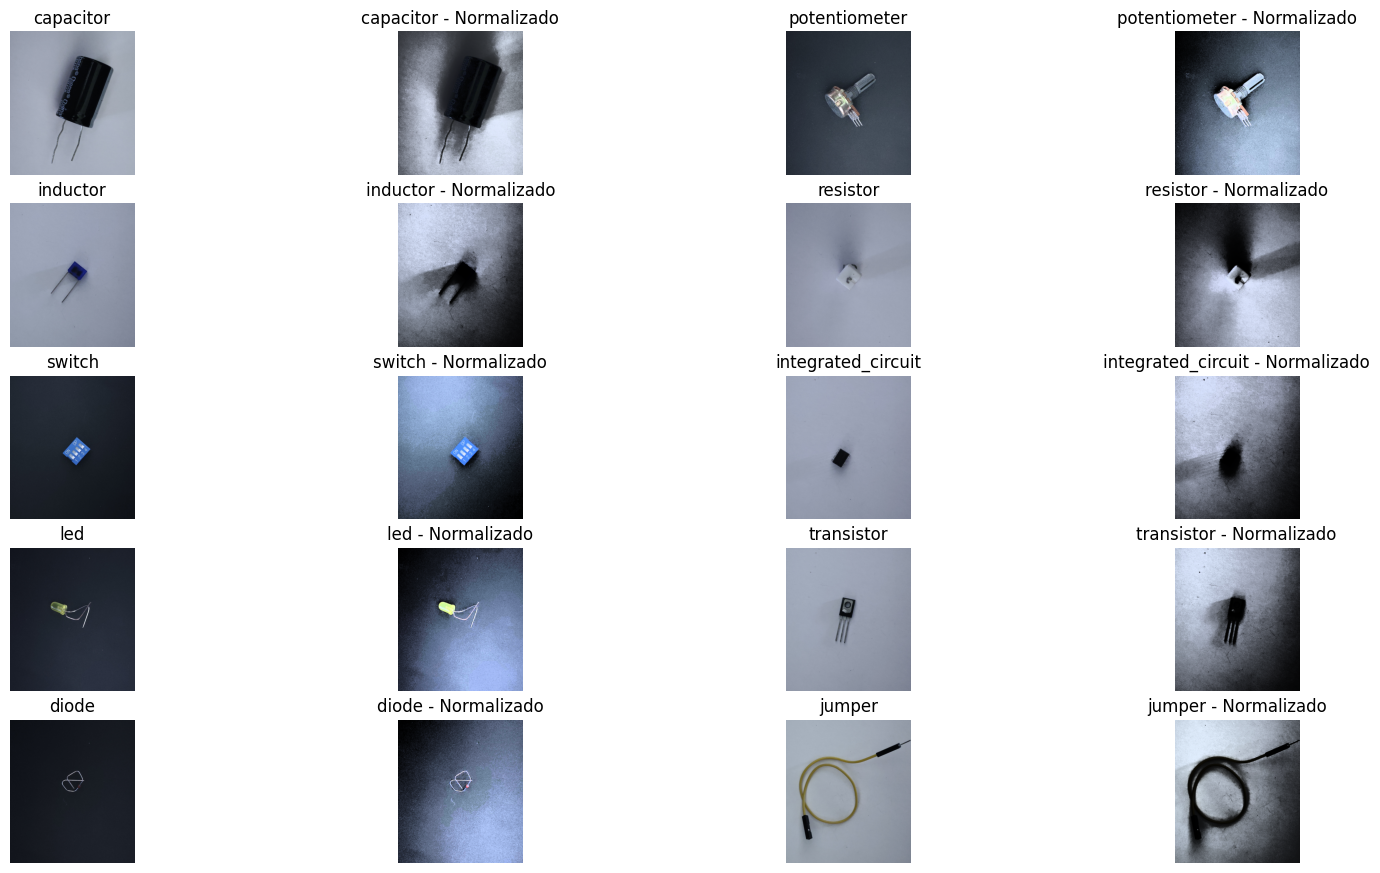

In [22]:
## Plotar um item de cada classe, original e normalizado por equalização de histograma

fig, ax = plt.subplots(5, 4, figsize=(19.2, 10.8))
ax = ax.ravel()
i = 0
for classe in img_data.keys():
  ax[i].imshow(img_data[classe][0])
  ax[i].set_title(classe)
  ax[i].set_axis_off()
  ax[i+1].imshow(norm_imgs[classe][0])
  ax[i+1].set_title(f'{classe} - Normalizado')
  ax[i+1].set_axis_off()
  i += 2

In [7]:
## Salvar dados:

# i = 0
# for classe in norm_imgs.keys():
#   for item in norm_imgs[classe]:
#     ski.io.imsave(f'./drive/MyDrive/PDI/normalized_dataset/{img_names[i][0]}/{img_names[i][1]}', item)
#     i += 1